# Classification with Decision Trees

## Import the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

Set the rng seed.

In [2]:
seed = 17

## Import and view data

In [3]:
df = pd.read_csv("data/train_prepd_2.csv")
display(df.head())
print('dims: ', df.shape)

,Survived,Pclass,Age,Fare,FamSize,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_Master,...,Title_Other,Deck_A,Deck_B,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_M,Deck_T
0,0.0,3,22.0,7.2500,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,1.0,1,38.0,71.2833,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1.0,3,26.0,7.9250,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1,35.0,53.1000,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,0.0,3,35.0,8.0500,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


dims:  (891, 23)


Decision trees do not support categorical data. Check data types.

In [4]:
df.dtypes

Survived        float64
Pclass            int64
Age             float64
Fare            float64
FamSize           int64
Sex_male          int64
Embarked_C        int64
Embarked_Q        int64
Embarked_S        int64
Title_Master      int64
Title_Miss        int64
Title_Mr          int64
Title_Mrs         int64
Title_Other       int64
Deck_A            int64
Deck_B            int64
Deck_C            int64
Deck_D            int64
Deck_E            int64
Deck_F            int64
Deck_G            int64
Deck_M            int64
Deck_T            int64
dtype: object

Split into dependent and independent variables.

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

## Build a preliminary classification tree

Split into train and test set. Because data are somewhat imbalanced (38% survived), we'll also use stratification.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, random_state = seed)

Build a basic decision tree model and predict the dependent variable for the test set.

Accuracy: 81.01 %


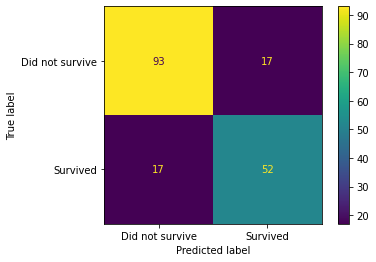

In [7]:
# Build the model shell and fit on the training set.
from sklearn.tree import DecisionTreeClassifier
clf_prel = DecisionTreeClassifier(criterion = 'gini', random_state = seed)
clf_prel.fit(X_train, y_train)

# Predict on the test set. 
y_pred = clf_prel.predict(X_test)

# Calculate accuracy and confusion matrix.
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

plot_confusion_matrix(clf_prel, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

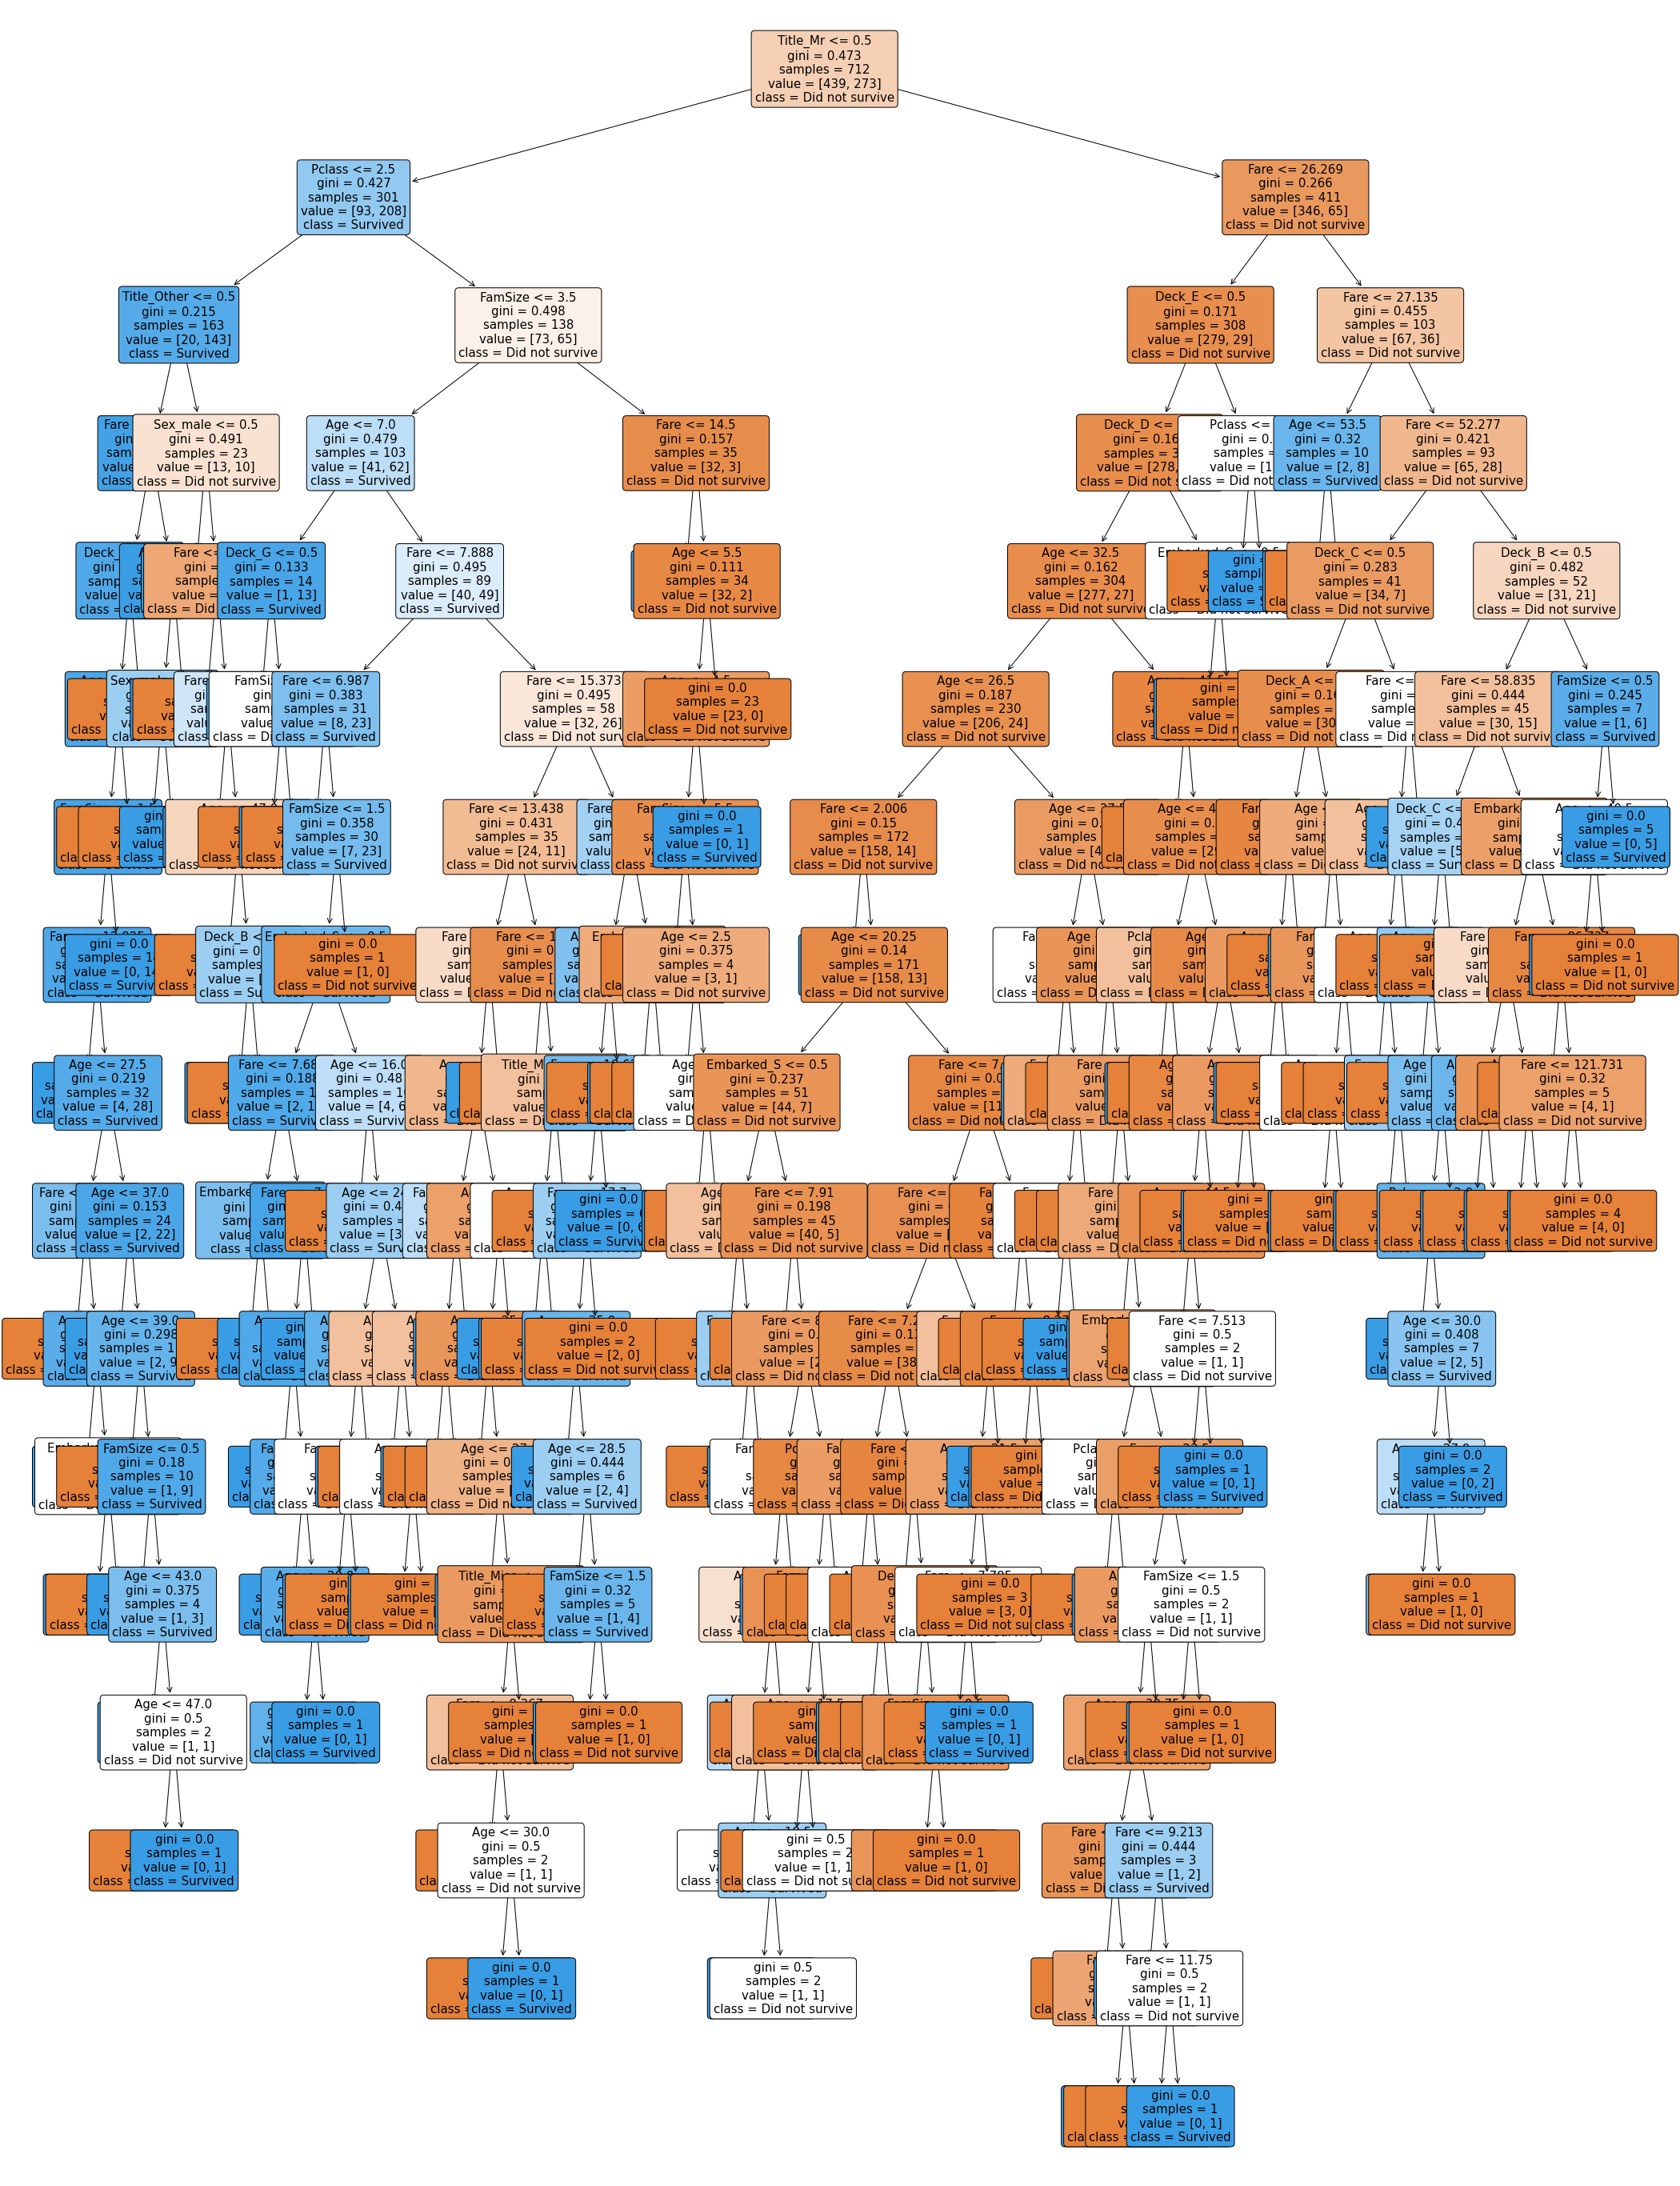

In [8]:
# Draw the decision tree.
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf_prel, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=15)


This is a huge tree, definitely overfitting the training data. Examine the fit on the training set.

Accuracy: 99.16 %


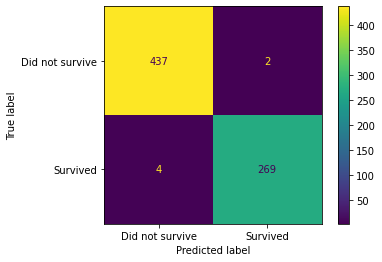

In [9]:
# Predict the dependent variable on the training set.
y_pred_tr = clf_prel.predict(X_train)

# Calculate accuracy and confusion matrix.
acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Draw the confusion matrix
plot_confusion_matrix(clf_prel, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Get a more robust estimate for the accuracy of the preliminary tree with 10-fold CV (repeated and stratified).

In [10]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf_prel, X, y, scoring='accuracy', n_jobs=-1, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))




scores:  [0.81111111 0.83146067 0.69662921 0.78651685 0.75280899 0.76404494
 0.85393258 0.78651685 0.83146067 0.84269663 0.8        0.79775281
 0.70786517 0.84269663 0.75280899 0.82022472 0.75280899 0.79775281
 0.84269663 0.74157303 0.83333333 0.75280899 0.82022472 0.79775281
 0.86516854 0.79775281 0.84269663 0.70786517 0.82022472 0.74157303
 0.82222222 0.82022472 0.7752809  0.73033708 0.74157303 0.78651685
 0.76404494 0.82022472 0.85393258 0.76404494 0.76666667 0.80898876
 0.83146067 0.7752809  0.73033708 0.7752809  0.80898876 0.80898876
 0.76404494 0.7752809 ]
Accuracy: 79.03 %
St.dev: 0.0413


## Hyperparameter tuning / Pruning the tree

The preliminary model is overfit on the training data. I'm going to attempt to find a smaller tree, to increase bias but lower variance. We will try Cost Complexity Pruning.

First, with a train test split.

In [11]:
# get alpha values from the full tree (train + test)
clf = DecisionTreeClassifier(criterion = 'gini', random_state = seed)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas = path.ccp_alphas
# omit the maximum value for alpha, as this is the trivial tree with only a root note.
ccp_alphas = ccp_alphas[:-1]

In [12]:
# now, using the train data, fit a tree on each value of alpha and store all of them in a list
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=seed, ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    dts.append(clf)  

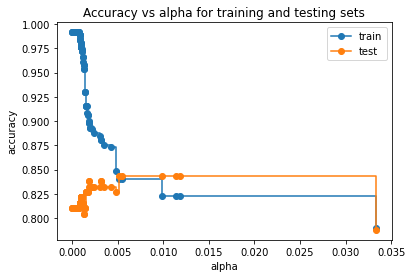

In [13]:
# get train and test scores for each tree
train_scores = [clf.score(X_train, y_train) for clf in dts]
test_scores = [clf.score(X_test, y_test) for clf in dts]


# plot accuracy vs alpha
fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [14]:
# return the alpha that yields the highest accuracy for the test set
d = {'alpha': ccp_alphas, 'train': train_scores, 'test': test_scores}
df = pd.DataFrame(data=d)

print('best tree: ')
df.loc[df['test'].idxmax()]

best tree: 


alpha    0.005125
train    0.839888
test     0.843575
Name: 73, dtype: float64

Then with cross validation, because different train test splits will result in different model accuracy. 

In [15]:
dts = []
for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini', random_state=seed, ccp_alpha=alpha)
    scores = cross_val_score(clf, X, y, cv=10)
    dts.append([alpha, np.mean(scores), np.std(scores)])

In [16]:
alpha_results = pd.DataFrame(dts, columns=['alpha', 'mean', 'std'])
alpha_results.head(50)

,alpha,mean,std
0,0.000000,0.782322,0.039885
1,0.000023,0.782322,0.039885
2,0.000047,0.782322,0.039885
3,0.000075,0.782322,0.039885
4,0.000087,0.782322,0.039885
5,0.000132,0.782322,0.039885
6,0.000187,0.782322,0.039885
7,0.000224,0.782322,0.039885
8,0.000271,0.781211,0.041362
9,0.000374,0.781211,0.041362


<AxesSubplot:xlabel='alpha'>

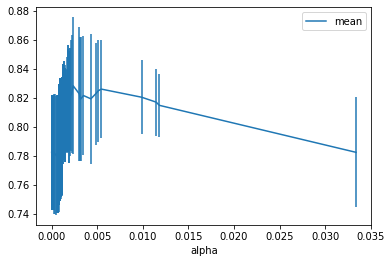

In [17]:
# plot mean accuracy and std. error for different values of alpha
alpha_results.plot(x='alpha', y='mean', yerr='std')

In [18]:
# return the alpha that yields the highest accuracy for the test set
print(alpha_results.loc[alpha_results['mean'].idxmax()])
alpha_best = alpha_results.loc[alpha_results['mean'].idxmax()][0]

alpha    0.002363
mean     0.828277
std      0.047434
Name: 66, dtype: float64


## Build the final model

Accuracy: 83.24 %


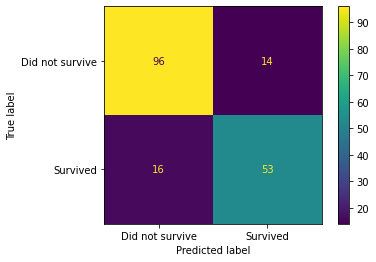

In [19]:
# Create model shell and fit on the training data.
clf = DecisionTreeClassifier(criterion = 'gini', ccp_alpha=alpha_best, random_state = seed)
clf.fit(X_train, y_train)

# Predict on the test data.
y_pred = clf.predict(X_test)

# Get accuracy and confusion matrix.
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Plot the confusion matrix.
plot_confusion_matrix(clf, 
                     X_test,
                     y_test, display_labels=['Did not survive', 'Survived'])

The tree seems to be doing a good job at correctly classifying those that did not survive (Sensitivity: 87%), but does not so well at correctly classifying those that survived (Specificity: 76%).

Plot the pruned tree.

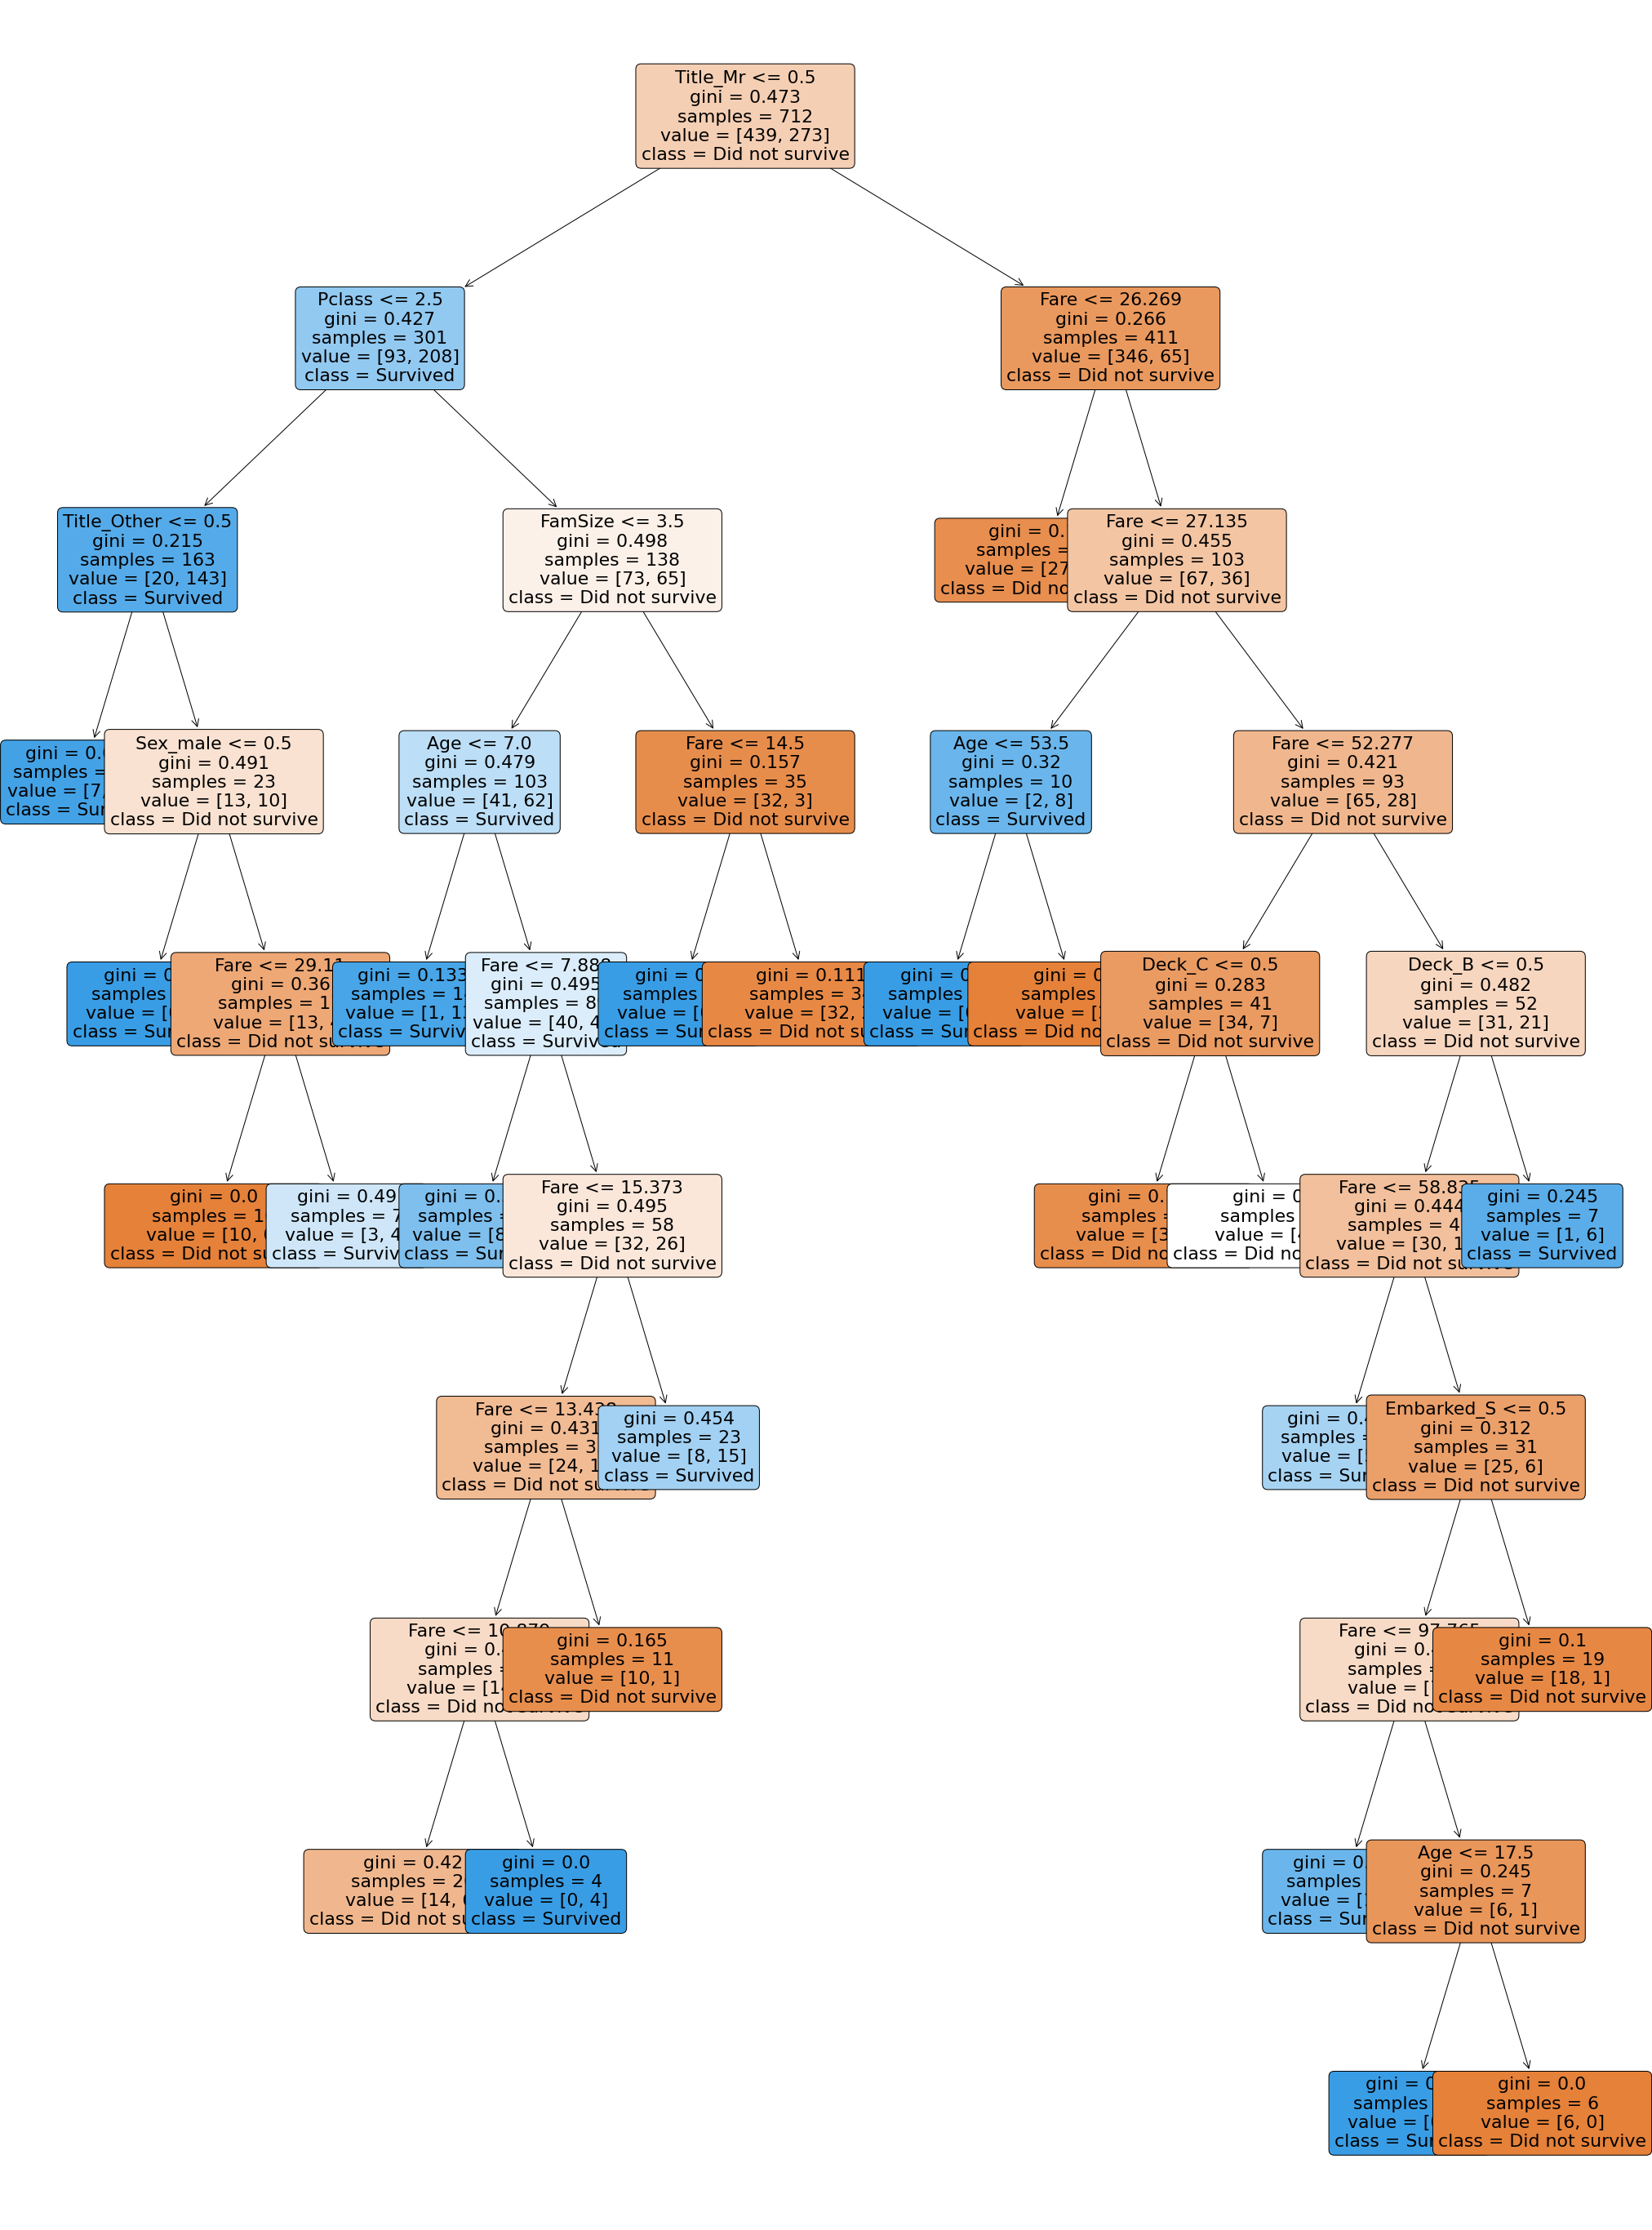

In [20]:
plt.figure(figsize=(35,50))
prel_tree = tree.plot_tree(clf, 
                   feature_names=pd.DataFrame(X).columns, 
                   class_names=["Did not survive", "Survived"],
                   filled=True,
                   rounded=True,
                  fontsize=22)

Re-assess overfitting by predicting the dependent variable on the training set.

Accuracy: 88.76 %


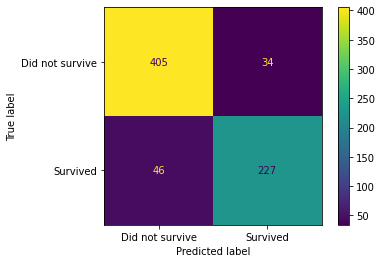

In [21]:
# Predict on the training data
y_pred_tr = clf.predict(X_train)

# Get accuracy and confusion matrix.
acc = accuracy_score(y_train, y_pred_tr)
cm = confusion_matrix(y_train, y_pred_tr)
print('Accuracy: {:.2f} %'.format(acc * 100))

# Plot the confusion matrix.
plot_confusion_matrix(clf, 
                     X_train,
                     y_train, display_labels=['Did not survive', 'Survived'])

Overfitting is significantly reduced.

Get a more robust estimate for the model accuracy, again using repeated and stratified 10-fold CV.

In [22]:
# Create the cv tactic.
cv_rep_str = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=seed)

# Get CV accuracy and st dev.
scores = cross_val_score(clf, X, y, scoring='accuracy', n_jobs=-1, cv=cv_rep_str)

print('scores: ', scores )
print('Accuracy: {:.2f} %'.format(scores.mean() * 100))
print('St.dev: {:.4f}'.format(scores.std()))


scores:  [0.85555556 0.86516854 0.76404494 0.79775281 0.78651685 0.7752809
 0.87640449 0.87640449 0.86516854 0.82022472 0.78888889 0.82022472
 0.80898876 0.82022472 0.80898876 0.78651685 0.82022472 0.86516854
 0.84269663 0.83146067 0.85555556 0.83146067 0.82022472 0.82022472
 0.84269663 0.78651685 0.86516854 0.80898876 0.79775281 0.7752809
 0.83333333 0.83146067 0.82022472 0.74157303 0.82022472 0.87640449
 0.80898876 0.79775281 0.86516854 0.79775281 0.78888889 0.82022472
 0.83146067 0.82022472 0.78651685 0.83146067 0.85393258 0.83146067
 0.78651685 0.7752809 ]
Accuracy: 82.00 %
St.dev: 0.0318


The final pruned tree performs about 3% better than the preliminary one (82% vs 79%)